In [1]:
import copy
import math
import pickle
import operator
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
def calc_shannon_ent(data_set):
    num_entries = len(data_set)
    label_count = {}
    for data in data_set:
        current_label = data[-1]
        if current_label not in label_count.keys():
            label_count[current_label] = 0
        label_count[current_label] += 1
    shannon_ent = 0.0
    for key in label_count.keys():
        prob = label_count[key] / num_entries
        shannon_ent += -prob * math.log(prob, 2)
    return shannon_ent

In [3]:
g_data_set = [[1, 1, 'yes'],
              [1, 1, 'yes'],
              [1, 0, 'no'],
              [0, 1, 'no'],
              [0, 1, 'no']]
g_labels = ['no surfacing', 'flippers']
calc_shannon_ent(g_data_set)

0.9709505944546686

In [4]:
def split_data_set(data_set, axis, value):
    ret_data_set = []
    for feat_vec in data_set:
        if feat_vec[axis] == value:
            reduced_feat_vec = feat_vec[: axis]
            reduced_feat_vec.extend(feat_vec[axis + 1: ])
            ret_data_set.append(reduced_feat_vec)
    return ret_data_set

In [5]:
split_data_set(g_data_set, 0, 0)

[[1, 'no'], [1, 'no']]

In [6]:
def choose_best_feature(data_set):
    num_features = len(data_set[0]) - 1
    base_entropy = calc_shannon_ent(data_set)
    best_info_gain = 0.0
    best_feature = -1
    for i in range(num_features):
        feat_list = [example[i] for example in data_set]
        unique_vals = set(feat_list)
        new_entropy = 0.0
        for value in unique_vals:
            sub_data_set = split_data_set(data_set, i, value)
            prob = len(sub_data_set) / float(len(data_set))
            new_entropy += prob * calc_shannon_ent(sub_data_set)
        info_gain = base_entropy - new_entropy
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = i
    return best_feature

In [7]:
choose_best_feature(data_set=g_data_set)

0

In [8]:
def majority_cnt(class_list):
    class_count = {}
    for vote in class_list:
        if vote not in class_count.keys():
            class_count[vote] = 0
        class_count[vote] += 1
    sorted_class_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_class_count[0][0]

In [9]:
def create_tree(data_set, labels):
    class_list = [example[-1] for example in data_set]
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]
    if len(data_set[0]) == 1:
        return majority_cnt(class_list)
    best_feat = choose_best_feature(data_set)
    best_feat_label = labels[best_feat]
    my_tree = {best_feat_label:{}}
    del labels[best_feat]
    feat_values = [example[best_feat] for example in data_set]
    unique_vals = set(feat_values)
    for value in unique_vals:
        sub_labels = labels[:]
        my_tree[best_feat_label][value] = create_tree(split_data_set(data_set, best_feat, value), sub_labels)
    return my_tree

In [10]:
create_tree(data_set=copy.deepcopy(g_data_set), labels=copy.deepcopy(g_labels))

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [11]:
%matplotlib inline
g_decision_node = dict(boxstyle="sawtooth", fc="0.8")
g_leaf_node = dict(boxstyle="round4", fc="0.8")
g_arrow_args = dict(arrowstyle="<-")
font = {'family': "SimHei"}
matplotlib.rc('font', **font)

In [12]:
def create_plot():
    fig = plt.figure(1, facecolor="white")
    fig.clf()
    create_plot.ax1 = plt.subplot(111, frameon=False)
    plot_node('决策节点', (0.5, 0.1), (0.1, 0.5), g_decision_node)
    plot_node('叶节点', (0.8, 0.1), (0.3, 0.8), g_leaf_node)
    plt.show()

def plot_node(node_txt, center_pt, parent_pt, node_type):
    create_plot.ax1.annotate(node_txt, xy=parent_pt, xycoords='axes fraction', xytext=center_pt,
                             textcoords='axes fraction', va='center', ha='center', bbox=node_type, arrowprops=g_arrow_args)

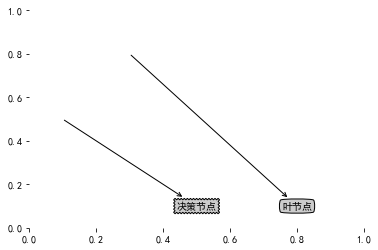

In [13]:
create_plot()

In [14]:
def get_num_leafs(my_tree:dict):
    num_leafs = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            num_leafs += get_num_leafs(second_dict[key])
        else:
            num_leafs += 1
    return num_leafs
def get_tree_depth(my_tree):
    max_depth = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            this_depth =  1 + get_tree_depth(second_dict[key])
        else:
            this_depth = 1
        if this_depth > max_depth:
            max_depth = this_depth
    return max_depth

In [15]:
g_my_tree = create_tree(data_set=copy.deepcopy(g_data_set), labels=copy.deepcopy(g_labels))
g_my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [16]:
get_tree_depth(g_my_tree)

2

In [17]:
get_num_leafs(g_my_tree)

3

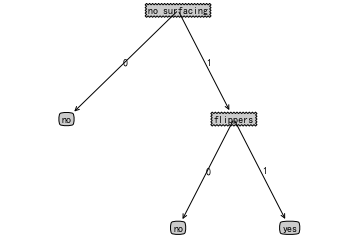

In [18]:
def plot_mid_text(cntr_pt, parent_pt, txt_string):
    x_mid = (parent_pt[0] + cntr_pt[0])/2.0
    y_mid = (parent_pt[1] + cntr_pt[1])/2.0
    create_plot.ax1.text(x_mid, y_mid, txt_string)

def plot_tree(my_tree:dict, parent_pt, node_txt):
    num_leafs = get_num_leafs(my_tree)
    depth = get_tree_depth(my_tree)
    first_str = list(my_tree.keys())[0]
    cntr_pt = (plot_tree.x_off + (1.0 + float(num_leafs))/2.0/plot_tree.total_w, plot_tree.y_off)
    plot_mid_text(cntr_pt, parent_pt, node_txt)
    plot_node(first_str, cntr_pt, parent_pt, g_decision_node)
    second_dict = my_tree[first_str]
    plot_tree.y_off = plot_tree.y_off - 1.0/plot_tree.total_d
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            plot_tree(second_dict[key], cntr_pt, str(key))
        else:
            plot_tree.x_off = plot_tree.x_off + 1.0/plot_tree.total_w
            plot_node(second_dict[key], (plot_tree.x_off, plot_tree.y_off), cntr_pt, g_leaf_node)
            plot_mid_text((plot_tree.x_off, plot_tree.y_off), cntr_pt, str(key))
    plot_tree.y_off = plot_tree.y_off + 1.0/plot_tree.total_d

def create_plot(in_tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plot_tree.total_w = float(get_num_leafs(in_tree))
    plot_tree.total_d = float(get_tree_depth(in_tree))
    plot_tree.x_off = -0.5/plot_tree.total_w
    plot_tree.y_off = 1.0
    plot_tree(in_tree, (0.5, 1.0), '')
    plt.show()
create_plot(g_my_tree)

In [19]:
def classify(input_tree, feat_labels, test_vec):
    first_str = list(input_tree.keys())[0]
    second_dict = input_tree[first_str]
    feat_index = feat_labels.index(first_str)
    for key in second_dict.keys():
        if test_vec[feat_index] == key:
            if type(second_dict[key]) is dict:
                class_label = classify(second_dict[key], feat_labels, test_vec)
            else:
                class_label = second_dict[key]
    return class_label

In [20]:
classify(g_my_tree, g_labels, [1, 1])

'yes'

In [21]:
def store_tree(input_tree, filename):
    with open(filename, 'wb') as fw:
        pickle.dump(input_tree, fw)

def grab_tree(filename):
    with open(filename, 'rb') as fr:
        return pickle.load(fr)

In [22]:
store_tree(g_my_tree, 'D:/classifier_storage.txt')

In [23]:
grab_tree('D:/classifier_storage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}, 'pre': 'soft', 'young': 'soft'}}, 'yes': {'prescript': {'hyper': {'age': {'presbyopic': 'no lenses', 'pre': 'no lenses', 'young': 'hard'}}, 'myope': 'hard'}}}}, 'reduced': 'no lenses'}}


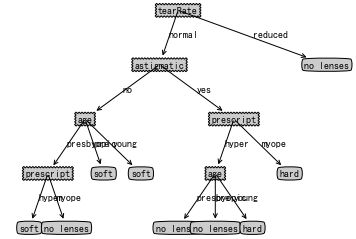

In [25]:
with open('D:/data/ch03/lenses.txt') as fr:
    lenses = [inst.strip().split('\t') for inst in fr.readlines()]
    lenses_labels = ['age', 'prescript', 'astigmatic', 'tearRate']
    lenses_tree = create_tree(lenses, lenses_labels)
    print(lenses_tree)
    create_plot(lenses_tree)